# Mario Christofell L.Tobing

Project 1 Dicoding Modul Belajar Pengembangan Machine Learning 

*   NLP Model for Classification Emotions in Text
*   Dataset download from Kaggle : Emotions in text (https://www.kaggle.com/datasets/ishantjuyal/emotions-in-text)



# Import Library

In [206]:
import pandas as pd
import nltk
import string
import os
import re
import tensorflow as tf
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Embedding
from keras.models import Model
from keras.callbacks import EarlyStopping

nltk.download('wordnet')
nltk.download('stopwords') 

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Import Dataset into Dataframe 

In [192]:
df = pd.read_csv('Emotion_final.csv') # Sumber dataset didownload dari Kaggle : Emotions in text (https://www.kaggle.com/datasets/ishantjuyal/emotions-in-text)
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [193]:
df.info() # info dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9895 entries, 0 to 9894
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     9895 non-null   object
 1   Emotion  9894 non-null   object
dtypes: object(2)
memory usage: 154.7+ KB


# Data Cleansing

In [194]:
def cleansing(Text): # kolom 'content' yang akan dibersihkan
    
    # Menghapus huruf yang berulang
    cn1 = re.sub(r'(.)\1+', r'\1\1', Text)
    # Menghapus tanda baca yang berulang
    cn2 = re.sub(r'[\?\.\!]+(?=[\?.\!])', '', cn1)
    # Menghapus angka atau karakter (hanya alphabet saja yang diambil)
    cn3 = re.sub(r'[^a-zA-Z]', ' ', cn2)
    # Case Folding
    cn4 = cn3.lower()
    return cn4
for i, r in df.iterrows():
    y = cleansing(r['Text'])
    df.loc[i, 'Text'] = y

stopwrd = stopwords.words() # menghapus stopwords (kata umum/tidak ada arti)
def stopword(Text):
    return(' '.join([w for w in Text.split() if w not in stopwrd ]))
    df.Text = df.Text.apply(lambda x: stopword(x))

lemma = WordNetLemmatizer() # lematization
def lem(Text):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemma.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(Text.split())]))
    df.Text = df.Text.apply(lambda x: lem(x))

df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


# Model

Dataset yang dipakai merupakan dataset multiclass/categorical sehinggga perlu dilakukan prose One Hot Encoding

In [197]:
# One Hot Encoding
category = pd.get_dummies(df.Emotion)
df_ohe = pd.concat([df, category], axis=1)
df_ohe = df_ohe.drop(columns='Emotion')
df_ohe.head(10)

,Text,anger,fear,happy,love,sadness,surprise
0,i didnt feel humiliated,0,0,0,0,1,0
1,i can go from feeling so hopeless to so damned...,0,0,0,0,1,0
2,im grabbing a minute to post i feel greedy wrong,1,0,0,0,0,0
3,i am ever feeling nostalgic about the fireplac...,0,0,0,1,0,0
4,i am feeling grouchy,1,0,0,0,0,0
5,ive been feeling a little burdened lately wasn...,0,0,0,0,1,0
6,ive been taking or milligrams or times recomme...,0,0,0,0,0,1
7,i feel as confused about life as a teenager or...,0,1,0,0,0,0
8,i have been with petronas for years i feel tha...,0,0,1,0,0,0
9,i feel romantic too,0,0,0,1,0,0


Mengubah nilai-nilai dari dataframe ke dalam tipe data numpy array menggunakan atribut values untuk dapat diproses oleh model

In [199]:
txt = df_ohe['Text'].values
label = df_ohe[['anger', 'fear', 'happy', 'love', 'sadness', 'surprise']].values

Split data for data training and data testing/validation

In [200]:
txt_latih, txt_test, label_latih, label_test = train_test_split(txt, label, test_size=0.2) # pembagian dataset untuk data test/validation sebesar 20% dari total keseluruhan data

Mengubah setiap kata pada dataset ke dalam bentuk bilangan numerik menggunakan Tokenizer dan konversi menjadi sequence

In [201]:
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(txt_latih)
tokenizer.fit_on_texts(txt_test)

sekuens_latih = tokenizer.texts_to_sequences(txt_latih)
sekuens_test = tokenizer.texts_to_sequences(txt_test)

padded_latih = pad_sequences(sekuens_latih)
padded_test = pad_sequences(sekuens_test)

Membangun arsitektur model dengan Sequential menggunakan layers LSTM dan Embedding lalu membuat fungsi compile dengan menentukan optimizer dan loss function yang dipakai oleh model  

In [203]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 64)          320000    
                                                                 
 lstm_10 (LSTM)              (None, 128)               98816     
                                                                 
 dense_26 (Dense)            (None, 128)               16512     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 6)                 774       
                                                                 
Total params: 436,102
Trainable params: 436,102
Non-trainable params: 0
_________________________________________________________________


Membuat fungsi callback untuk memberi perintah berhenti melatih kepada model jika akurasi validasi sudah mencapai > 90% 

In [204]:
class myCallback(tf.keras.callbacks.Callback): #fungsi callback
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      self.model.stop_training = True
      print("\nThe val_accuracy has reached > 90%!")
callbacks = myCallback()

Mulai melatih model dengan fungsi fit

In [205]:
num_epochs = 50
history = model.fit(padded_latih, label_latih, epochs=num_epochs,
                    validation_data=(padded_test, label_test), verbose=2, callbacks=[callbacks], validation_steps=30)

Epoch 1/50
248/248 - 29s - loss: 1.5383 - accuracy: 0.3723 - val_loss: 1.1909 - val_accuracy: 0.5649 - 29s/epoch - 116ms/step
Epoch 2/50
248/248 - 26s - loss: 0.8054 - accuracy: 0.7153 - val_loss: 0.7242 - val_accuracy: 0.7377 - 26s/epoch - 103ms/step
Epoch 3/50
248/248 - 25s - loss: 0.3789 - accuracy: 0.8714 - val_loss: 0.4691 - val_accuracy: 0.8575 - 25s/epoch - 103ms/step
Epoch 4/50
248/248 - 25s - loss: 0.2040 - accuracy: 0.9363 - val_loss: 0.3981 - val_accuracy: 0.8782 - 25s/epoch - 102ms/step
Epoch 5/50
248/248 - 26s - loss: 0.1229 - accuracy: 0.9596 - val_loss: 0.4324 - val_accuracy: 0.8807 - 26s/epoch - 103ms/step
Epoch 6/50
248/248 - 25s - loss: 0.0916 - accuracy: 0.9697 - val_loss: 0.3879 - val_accuracy: 0.8924 - 25s/epoch - 102ms/step
Epoch 7/50
248/248 - 26s - loss: 0.0710 - accuracy: 0.9765 - val_loss: 0.4808 - val_accuracy: 0.8924 - 26s/epoch - 103ms/step
Epoch 8/50
248/248 - 26s - loss: 0.0600 - accuracy: 0.9800 - val_loss: 0.4778 - val_accuracy: 0.8863 - 26s/epoch - 103

# Visualization Plot Accuracy and Loss from Model

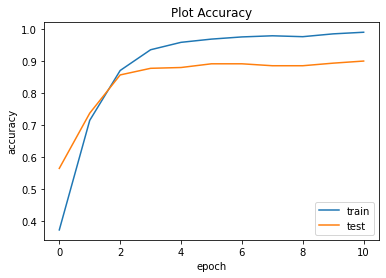

In [214]:
plt.plot(history.history['accuracy']) # plot accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Plot Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

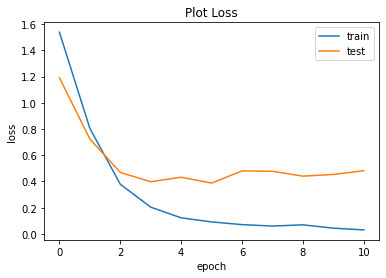

In [213]:
plt.plot(history.history['loss']) # plot loss
plt.plot(history.history['val_loss'])
plt.title('Plot Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()